In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import signal, linalg
from ipywidgets import interact

In [2]:
import sklearn
from scipy import linalg, signal, optimize
import lockin
import phasekick2 as pk2
import phasekick as pk
import tqdm
import sigutils
import munch
from timedomainfit import *
import timedomainfit as td

def print_popt(x, cov=None, print_string=True):
    names = ["f_i = {:8.1f}{}Hz",
             " df = {:8.1f}{}Hz",
             "f_f = {:8.1f}{}Hz",
             " X0 = {:8.1f}{}nm",
             " Y0 = {:8.1f}{}nm",
            u" τ1 = {:8.1f}{}µs",
            u" τ2 = {:8.1f}{}µs",
            u"  r = {:8.2f}{}",
             " Q0 = {:8.0f}{}",
             "Qhv = {:8.0f}{}",
            u" Δx = {:8.2f}{}nm"
            ]
    scales = [1, 1, 1, 1, 1, 1e6, 1e6, 1, 1, 1, 1]
    string = []
    if cov is None:
        covs = [" " for i in x]

    for n, name, cov, scale in zip(x, names, covs, scales):
        string.append(name.format(n*scale, cov))
    string = "\n".join(string)
    if print_string:
        print(string)
    return string

def plot_lis(lis, y):
    fig, ax = plt.subplots()
    for li in lis:
        ax.plot(li('t'), li(y), label=li.name)
    
    return fig, ax

In [3]:
# A = 0.05
# Lambda = 1.488
# t = np.linspace(0, 2*np.pi, 128, endpoint=False)
# x0 = 0.02
# xt = A * np.sin(t) + x0
# V = np.sin((4 * np.pi * xt) / Lambda)

# def wave(t, A, x0):
#     return A * np.sin(t) + x0

# def interf(x, Lambda):
#     return (np.sin((4 * np.pi * x)/Lambda) - x * 4 * np.pi / Lambda)

In [4]:
fs = 1e6
ba = signal.butter(2, np.array([1e3, 200e3]) / (fs/2), analog=False, btype='bandpass')

In [5]:
phit, optfunc, optfuncQ, optfuncDC, optfuncDet, xDCt, xDC_all = td.make_optfunc(t0=0, tp=1.4e-3)

In [6]:
fh = h5py.File("../../data/tr-efm/151218-003450-100sun-784.h5", "r")
params =   {'fp': 4000,
             'fc': 15000,
             't_phase': -0.052,
             'ti': -54e-3,
             'tf': 6e-3,
             'Ndec': 1}
fir = lockin.lock2(66000, params['fp'], params['fc'], fs=1e6)

Response:
f   mag       dB
    0.000 1.000    0.000
 2000.000 0.982   -0.161
 4000.000 0.921   -0.715
15000.000 0.098  -20.164
30000.000 0.000 -101.125
33000.000 0.000 -110.366
66000.000 0.000 -141.187
500000.000 0.000 -196.320


In [7]:
b = td.signal_average_gr_parab(fh['data'], -1.5e-3, 0, invert=False)

100%|██████████| 784/784 [00:07<00:00, 101.43it/s]
1500it [00:00, 2853.32it/s]

Response:
f   mag       dB
    0.000 1.000    0.000
 3091.925 0.983   -0.152
 6183.850 0.927   -0.658
24735.399 0.095  -20.423
30919.249 0.011  -38.978
49470.798 0.000 -101.893
61838.498 0.000 -110.800
500000.000 0.000 -339.063


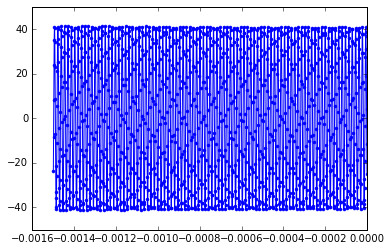

In [8]:
plt.plot(b.t, b.x, marker='.')

In [9]:
t= (b.t - b.t[0]) * 1e3
f = 61.850
X = -23
Y= 30
fit = X * np.cos(2*np.pi*f*t) + Y * np.sin(2*np.pi*f*t)

In [10]:
def sine(t, X, Y, f):
    return X * np.cos(2*np.pi*f*t) + Y * np.sin(2*np.pi*f*t)

In [11]:
def sineQ(t, X, Y, f, k, x0):
    return np.exp(-k * (t-t[0])) * sine(t, X, Y, f) + x0

In [12]:
def interferom_sine(t, X, Y, f, kringdown, x0, phi, k):
    x = sineQ(t, X, Y, f, kringdown, x0)
    Lambda = 1488.0
    return k*(Lambda / (4 * np.pi)) * (np.cos(phi) * np.sin((4 * np.pi * x)/Lambda) + np.sin(phi) * (1 - np.cos(4 * np.pi * x / Lambda)))

In [13]:
p0 = np.array([-23, 30, 61.850, 0.1, 0.0])

In [14]:
popt, pcov = optimize.curve_fit(sineQ, t, b.x, p0=p0)
resid = b.x - sineQ(t, *popt)

In [15]:
popt

array([ -2.25546663e+01,   3.46898430e+01,   6.18405206e+01,
         8.96076892e-03,  -9.68244271e-02])

In [16]:
popt2

NameError: name 'popt2' is not defined

In [ ]:
popt2, pcov2 = optimize.curve_fit(interferom_sine, t, b.x,
                                  p0=np.array([ -2.25544427e+01,   3.46875878e+01,   6.18405245e+01,
         9.6e-3, -0.127, 0.0, 1.0]))
resid2 = b.x - interferom_sine(t, *popt2)

In [ ]:
popt2

In [ ]:
plt.plot(b.li('t')*1e3, b.li('A'))
plt.plot(b.li('t')*1e3, np.exp(-(b.li('t') - b.li('t')[0])*9.6e-3 * 1e3) * 41.35)

In [ ]:
phi0 / (2*np.pi) * 16.08

In [ ]:
plt.plot(t, resid, 'b.')
plt.plot(t, resid2, 'g.')

In [ ]:
def harmonics(t, X2, Y2, X3, Y3, X4, Y4, X5, Y5):
    f = popt[2]
    return (X2 * np.cos(4*np.pi*f*t) + Y2 * np.sin(4*np.pi*f*t) + X3 * np.cos(6*np.pi*f*t) + Y3 * np.cos(6*np.pi*f*t) +
            X4 * np.cos(10*np.pi*f*t) + Y4 * np.cos(10*np.pi*f*t) +
            X5 * np.cos(10*np.pi*f*t) + Y5 * np.cos(10*np.pi*f*t))

In [ ]:
def harN(t, f, N, A=1):
    cols = []
    for i in xrange(2, N+1):
        cols.extend([A*np.cos(t*2*np.pi*f*i), A*np.sin(t*2*np.pi*f*i)])
    return np.c_[cols].T

In [ ]:
A = harN(t, popt[2], 5, np.exp(-t * popt[3]))

In [ ]:
x_har, __, ___, ____ = linalg.lstsq(A, resid)

In [ ]:
# plt.plot(t % (1.0/popt2[2]), resid2, '.')
plt.plot(t % (1.0/popt[2]), resid, '.')
plt.plot(t % (1.0/popt[2]), harmonics(t, *popt_har), '.')
plt.plot(t % (1.0/popt[2]), np.dot(A, x_har), '.')

In [ ]:
x2 = b.x - np.dot(A, x_har)

In [ ]:
popt2, pcov2 = optimize.curve_fit(sineQ, t, x2, p0=popt)

In [ ]:
popt2

In [ ]:
popt

In [ ]:
b2 = td.signal_average_gr_parab(fh['data'], -1.5e-3, 1.4e-3, invert=False)

In [ ]:
t2 = (b2.t - b2.t[0])*1e3

In [ ]:
t2_0 = b2.t[0]*1e3

In [ ]:
Aall = harN(t2, popt2[2], 5, np.exp(-t2*popt[3]))
x2all = b2.x - np.dot(Aall, x_har)

In [ ]:
resid_all = x2all - sineQ(t2, *popt2)

In [ ]:
plt.plot((t2 + t2_0)*1e3, resid_all, '-', linewidth=0.5, color='0.5')
plt.plot(1e3*(t2 + t2_0), resid_all, '.',)
plt.xlim(-20, 70)
plt.ylim(-0.05, 0.9)

In [ ]:
plt.plot(t % (1.0/popt2[2]), x2 - sineQ(t, *popt2), '.')

In [ ]:
plt.plot(t, resid - np.dot(A, x_har), '.')

In [ ]:
plt.plot(t % (1.0/popt[2]), resid - np.dot(A, x_har), '.')

In [ ]:
psd = signal.periodogram(resid,  fs=1e3)
psd2 =  signal.periodogram(resid2,  fs=1e3) 

In [ ]:
plt.plot(*signal.periodogram(b.x, fs=1e3, window='blackman'))
plt.loglog(*psd)
plt.loglog(*psd2)
plt.ylim(1e-8, 1)